In [7]:
import pickle
import numpy as np
import torch
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
import gc
from copy import deepcopy

# MDN method and APS score and method
from Epistemic_CP.epistemic_cp import ECP_split, APSSplit
from Epistemic_CP.scores import APSScore

# for anomaly detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score

# feature extraction libraries
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# base models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
from tqdm import tqdm
import textwrap
# Enable LaTeX rendering in matplotlib
plt.rcParams['text.usetex'] = True

Defining RestNet34 pre-fitted model:

In [8]:
# importing resnet model
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# Send the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# path
original_path = os.getcwd()

Making a function to pre-process the images and convert them to a covariate matrix:

In [9]:
def feature_extraction(images, 
                       model,
                       device,
                       batch_size = 500,
                       preprocessing_batch_size = 20,):
    # Send the model to the GPU
    model = model.to(device)
    # function to extract features
    feature_extractor = create_feature_extractor(model, 
                                                 return_nodes={'avgpool': 'features'}
                                                 )
    # preprocessing functions
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]),
    ])

    # Transform the dataset
    def transform_image(image):
        image = preprocess(image)
        return image
    
    # feature list
    feature_list = []
    
    for i in tqdm(range(0, len(images), batch_size), 
                  desc = "Performing feature extraction"):
        batch = images[i:i + batch_size]
        transformed_batches = []

        for i in range(0, len(batch), preprocessing_batch_size):
            pre_batch = batch[i:i + preprocessing_batch_size]
            transformed_batch = torch.stack(
                [transform_image(image) for image in pre_batch])
            transformed_batches.append(transformed_batch)

        # Concatenate all batches into a single tensor
        transformed_data = torch.cat(transformed_batches)

        # delete original batch for memory purposes
        del batch
        gc.collect()

        # Move the model to the same device as the data
        model = model.to(device)

        # Move the transformed_train_data to the same device as the model
        transformed_data = transformed_data.to(device)

        # Extract features
        with torch.no_grad():
            features = feature_extractor(transformed_data)['features']
        
        # deleting transformed_data
        transformed_data = transformed_data.cpu()
        # deleting object
        del transformed_data
        gc.collect()
        
        # Flatten the features to 2D
        features_2d = features.view(features.size(0), -1)
        features_numpy = features_2d.cpu().numpy()

        # concatenating
        feature_list.append(features_numpy)
    return feature_list

In [10]:
def ssc_metric(pred_sets,
               label_true,
               label_numbers,
               G = 7,
               violation = False,
               alpha = 0.1,
               ):
    # dividing into G subgroups
    card_idx = np.arange(0, G)
    i = 0
    prob_array = np.zeros(G)
    # computing each prediction set cardinality
    card_pred = pred_sets.sum(axis = 1)
    for card in card_idx:
        if i+1 == G:
            filter = np.where(card_pred > (card + 1))[0]
        else:
            filter = np.where(card_pred == (card + 1))[0]
        
        bin_size = filter.shape[0]

        if bin_size > 0:
            # filtering the prediction sets
            pred_filter = pred_sets[filter, :]
            coverage_array = np.zeros(bin_size)
            label_filter = label_true[filter]

            for j in range(bin_size):
                idxs = label_numbers[pred_filter[j, :]]
                coverage_array[j] = int(np.isin(label_filter[j], 
                                                idxs))
        
            prob_array[i] = np.mean(coverage_array)
        else:
            prob_array[i] = np.nan
        i += 1
    
    if violation:
        # filtering arrays
        prob_array = prob_array[~np.isnan(prob_array)]
        sscv = np.max(np.abs(prob_array - (1 - alpha)))
        return sscv
    else:
        # selecting minimum prob
        prob_min = np.nanmin(prob_array)
        return prob_min

# Experiments with CIFAR-100:

## Pre-processing data:

Downloading CIFAR-100 dataset:

In [11]:
import tarfile
import urllib.request

# URL for the CIFAR-100 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
folder_path = "cifar-100-python"

# Download the dataset
urllib.request.urlretrieve(url, filename)

# Extract the dataset
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()
os.remove(filename)

Reading CIFAR-100 dataset:

In [12]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

folder_path = "cifar-100-python"

files = os.listdir(folder_path)

data_list = []
labels_list = []
for file_name in files:
    if file_name != 'file.txt~':
        metadata = unpickle(folder_path + "/" + file_name)
        if file_name == "meta":
            label_names = metadata[b'fine_label_names']
        else:
            data = metadata[b'data']
            labels = metadata[b'fine_labels']
            data_list.append(data)
            labels_list.append(labels)

Decoding label names:

In [13]:
label_names = [label.decode('utf-8') for label in label_names]
print(label_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

Reshaping and splitting data:

In [14]:
# concatenating data
data_all = np.concatenate(data_list, axis=0)
labels_all = np.concatenate(labels_list, axis=0)

# reshaping data so it fits inside a 32x32 matrix
n_obs = data_all.shape[0]
data_recoded = data_all.reshape(n_obs, 3, 32, 32).transpose(0, 2, 3, 1)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    data_recoded, 
    labels_all, 
    test_size=0.1, 
    random_state=45)

# Further split the training data into training and calibration sets
train_images, cal_images, train_labels, cal_labels = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.5, 
    random_state=45)

Performing feature extraction in each set:

In [15]:
# for training set
train_list = feature_extraction(train_images,
                                model,
                                device)
X_train = np.concatenate(train_list, axis=0)
del train_list
gc.collect()

# for calibration set
cal_list = feature_extraction(cal_images,
                              model,
                              device)
X_cal = np.concatenate(cal_list, axis = 0)
del cal_list
gc.collect()

# for testing set
test_list = feature_extraction(test_images,
                              model,
                              device)
X_test = np.concatenate(test_list, axis = 0)
del test_list
gc.collect()

Performing feature extraction: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


2292

## Fitting base model:

Fitting random forest in processed data:

In [16]:
# Random forest
rf_model = RandomForestClassifier(n_estimators=300, 
                                  random_state=42, 
                                  n_jobs=-1
                                  )

# Fit the model on the training data
rf_model.fit(X_train, train_labels)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

analysing accuracy:

In [17]:
# Predict the labels for the calibration set
test_predictions = rf_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"RF Accuracy: {accuracy}")

RF Accuracy: 0.4661666666666667


## Fitting CP methods:

Using our formal classes, first fitting APS:

In [18]:
np.random.seed(45)
torch.cuda.manual_seed(35)
torch.manual_seed(35)

# fitting first APS
alpha = 0.2
aps_obj = APSSplit(rf_model, alpha = alpha, is_fitted = True)
aps_obj.fit(X_train, train_labels)
aps_obj.calibrate(X_cal, cal_labels)

Fitting EPICSCORE-MDN with normalization:

Fitting MDN model:   5%|▌         | 108/2000 [00:42<12:32,  2.52it/s]

Early stopping na época 108 com a melhor perda de validação: 0.9755


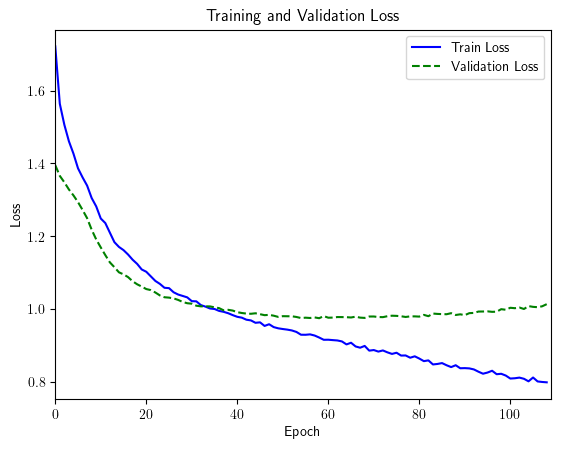

0.8263979819417001

In [19]:
ecp_obj = ECP_split(APSScore, 
                    base_model = rf_model,
                    alpha = alpha,
                    is_fitted = True,
                    )

ecp_obj.fit(X_train, train_labels)
ecp_obj.calib(
    X_cal,
    cal_labels,
    num_components = 3,
    dropout_rate = 0.5,
    epistemic_model = "MC_dropout",
    hidden_layers = [64, 64, 32],
    patience = 50,
    epochs = 2000,
    scale = True,
    batch_size = 135,
    verbose = 2,
    normalize_y = True,
    type = "gaussian"
    )

Predicting images:

In [20]:
# obtaining prediction sets
# label strings
label_strings = np.array(label_names)

# Predicting all testing samples
pred_sets_aps = aps_obj.predict(X_test)
pred_sets_mdn = ecp_obj.predict(X_test)

Computing coverage violation:

In [21]:
sscv_aps = ssc_metric(pred_sets_aps,
           test_labels,
           label_numbers = np.arange(0, 100),
           G = 30,
           violation = True,
           alpha = alpha)

sscv_mdn = ssc_metric(pred_sets_mdn,
                     test_labels,
                     label_numbers = np.arange(0, 100),
                     G = 30,
                     violation = True,
                     alpha = alpha)

print(f"SSCV APS: {sscv_aps}, SSCV MDN: {sscv_mdn}")

SSCV APS: 0.30000000000000004, SSCV MDN: 0.11044776119402977


## Further Analysis of prediction sets

In [22]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_test = tsne.fit_transform(X_test)

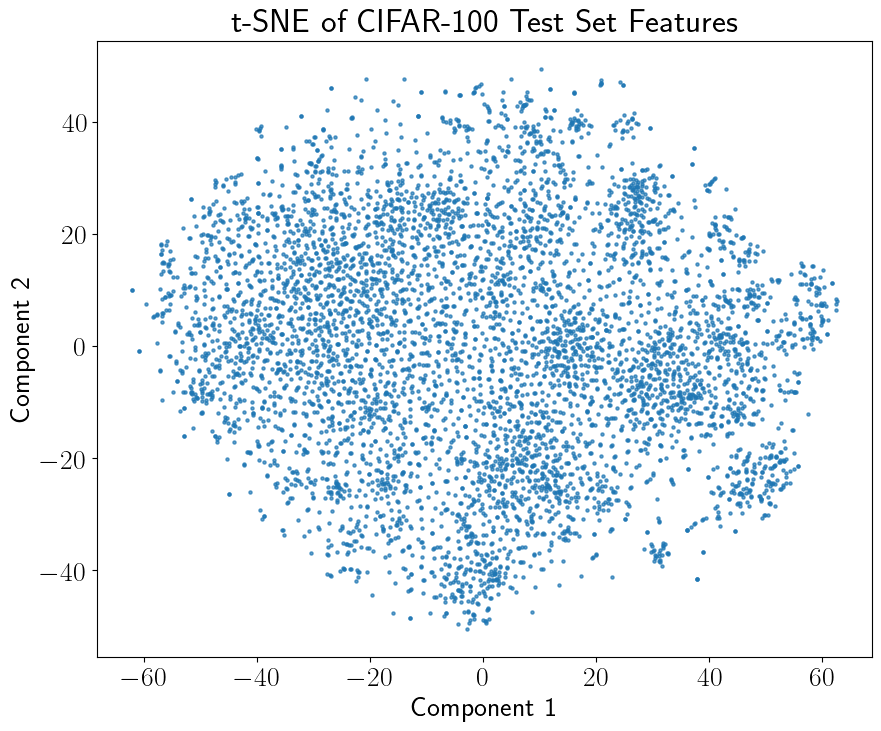

In [23]:
# plotting t-sne
plt.rcParams.update({'font.size': 20})

# Plot the first two components for the test set
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_test[:, 0], X_tsne_test[:, 1], s=5, alpha=0.7)
plt.title('t-SNE of CIFAR-100 Test Set Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Performing outlier detection:

In [24]:
# Use t-SNE components instead of original features
X_test_sne = X_tsne_test
# Standardize the features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_sne)

# Use Local Outlier Factor for anomaly detection on scaled data
lof = LocalOutlierFactor(n_neighbors=25, contamination=0.1)
y_pred = lof.fit_predict(X_test_scaled)
# outliers indexes
outlier_images = test_images[y_pred == -1]
outlier_indexes = np.where(y_pred == -1)[0]

# Select 2 most contaminated images for example
contamination_scores = lof.negative_outlier_factor_[outlier_indexes]
most_cont_idx = np.argsort(contamination_scores)[np.array([6, 9])]
most_cont_labels = test_labels[outlier_indexes][most_cont_idx]
most_cont_im = outlier_images[most_cont_idx]

# Identify also the inliers (non-outliers)
inlier_indexes = np.setdiff1d(np.arange(len(test_images)), outlier_indexes)

# Select the 2 inliers based on the highest scores (least negative) for example
inlier_scores = lof.negative_outlier_factor_[inlier_indexes]
most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([0, 26])]
most_common_inlier_indexes = inlier_indexes[most_inlier_idx]

# Select the most common images among inliers
most_common_inlier_labels = test_labels[most_common_inlier_indexes]
most_common_inlier_images = test_images[most_common_inlier_indexes]

Filtering prediction sets according to outliers and inliers:

In [25]:
# Predict the labels for the test set
test_predictions = rf_model.predict(X_test)

# Identify incorrectly predicted labels in the test set
incorrect_test_indexes = np.where(test_labels != test_predictions)[0]
incorrect_test_images = test_images[incorrect_test_indexes]

mdn_outlier_sets = pred_sets_mdn[outlier_indexes]
aps_outlier_sets = pred_sets_aps[outlier_indexes]

most_cont_mdn_sets = mdn_outlier_sets[most_cont_idx]
most_cont_aps_sets = aps_outlier_sets[most_cont_idx]

Outlier Illustration:

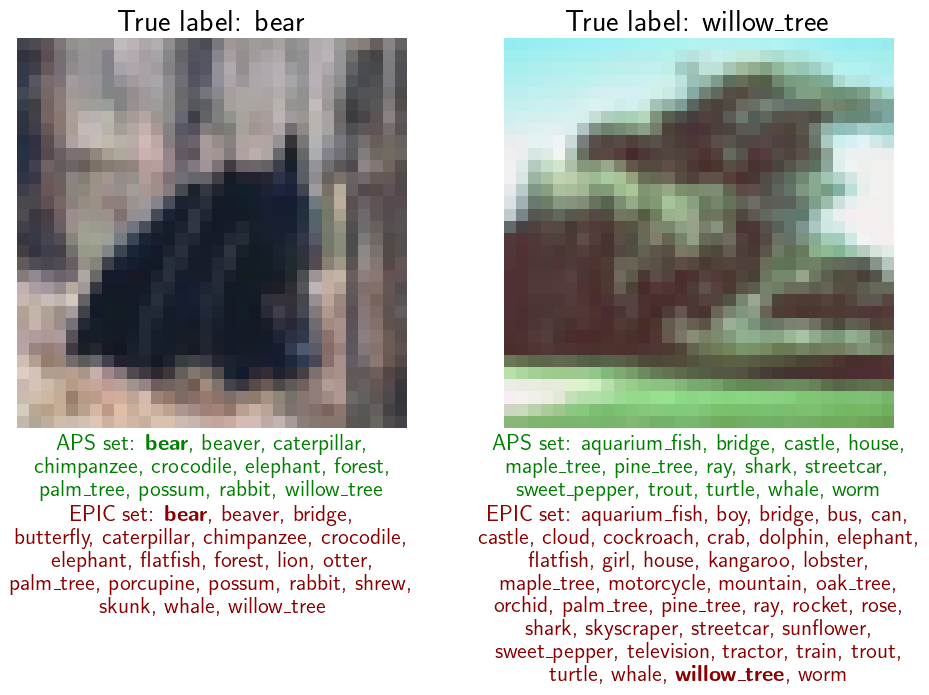

In [37]:
plt.rcParams.update({'font.size': 22})
# Define the number of rows and columns for the subplot
rows, cols = 1, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
plt.rcParams.update({'font.size': 18})


# Plot and save each image with the labels separately
for i, ax in enumerate(axes.flat):
    if i < len(most_cont_im):
        ax.imshow(most_cont_im[i].astype(np.uint8))

        true_label = most_cont_labels[i]
        aps_set = list(label_strings[most_cont_aps_sets[i, :]])
        mdn_set = list(label_strings[most_cont_mdn_sets[i, :]])

        if label_strings[true_label] in aps_set:
            aps_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in aps_set]
        else:
            aps_set_highlighted = aps_set

        if label_strings[true_label] in mdn_set:
            mdn_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in mdn_set]
        else:
            mdn_set_highlighted = mdn_set
            
       # Adjust the spacing of the text
        aps_text = "APS set: {}".format(", ".join(aps_set_highlighted))
        mdn_text = "EPIC set: {}".format(", ".join(mdn_set_highlighted))

        # Wrap the text to fit within the plot
        aps_text_wrapped = "\n".join(textwrap.wrap(aps_text, width=50))
        mdn_text_wrapped = "\n".join(textwrap.wrap(mdn_text, width=50))

        ax.set_title(f"True label: {label_strings[true_label]}")
        ax.axis('off')
        if i == 0:
            ax.text(0.5, -0.175, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16,transform=ax.transAxes, color='green')
            ax.text(0.5, -0.475, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16,transform=ax.transAxes, color='darkred')
        else:
            ax.text(0.5, -0.175, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16,transform=ax.transAxes, color='green')
            ax.text(0.5, -0.65, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16,transform=ax.transAxes, color='darkred')
        ax.axis('off')

plt.tight_layout()
plt.show()
    

Selecting inliers:

In [39]:
# Identify inliers (non-outliers)
inlier_indexes = np.setdiff1d(np.arange(len(test_images)), outlier_indexes)

# Select the 4 most common inliers based on the highest scores (least negative)
inlier_scores = lof.negative_outlier_factor_[inlier_indexes]
# most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([0, 26, 18])]
most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([0, 26])]
most_common_inlier_indexes = inlier_indexes[most_inlier_idx]

# Select the most common images among inliers
most_common_inlier_labels = test_labels[most_common_inlier_indexes]
most_common_inlier_images = test_images[most_common_inlier_indexes]

# Obtain the prediction sets for these most common inlier images
most_common_inlier_aps_sets = pred_sets_aps[most_common_inlier_indexes]
most_common_inlier_mdn_sets = pred_sets_mdn[most_common_inlier_indexes]

Inlier illustration:

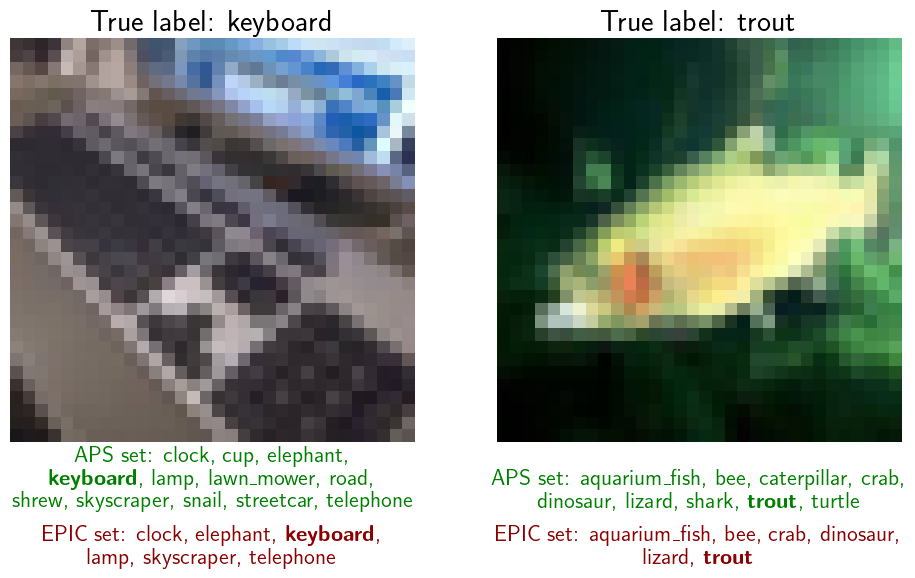

In [44]:
# Define the number of rows and columns for the subplot
rows, cols = 1, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
plt.rcParams.update({'font.size': 18})

# Plot each image with the APS set and EPIC set
for i, ax in enumerate(axes.flat):
    if i < len(most_common_inlier_images):
        ax.imshow(most_common_inlier_images[i].astype(np.uint8))
        true_label = most_common_inlier_labels[i]
        aps_set = list(label_strings[most_common_inlier_aps_sets[i, :]])
        mdn_set = list(label_strings[most_common_inlier_mdn_sets[i, :]])

        if label_strings[true_label] in aps_set:
            aps_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in aps_set]
        else:
            aps_set_highlighted = aps_set

        if label_strings[true_label] in mdn_set:
            mdn_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in mdn_set]
        else:
            mdn_set_highlighted = mdn_set

        # Adjust the spacing of the text
        aps_text = "APS set: {}".format(", ".join(aps_set_highlighted))
        mdn_text = "EPIC set: {}".format(", ".join(mdn_set_highlighted))

        # Wrap the text to fit within the plot
        aps_text_wrapped = "\n".join(textwrap.wrap(aps_text, width=50))
        mdn_text_wrapped = "\n".join(textwrap.wrap(mdn_text, width=50))

        ax.set_title(f"True label: {label_strings[true_label]}")
        ax.axis('off')
        ax.text(0.5, -0.16, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
        ax.text(0.5, -0.3, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')

plt.tight_layout()
plt.show()

Highlighting outliers and inliers in t-sne:

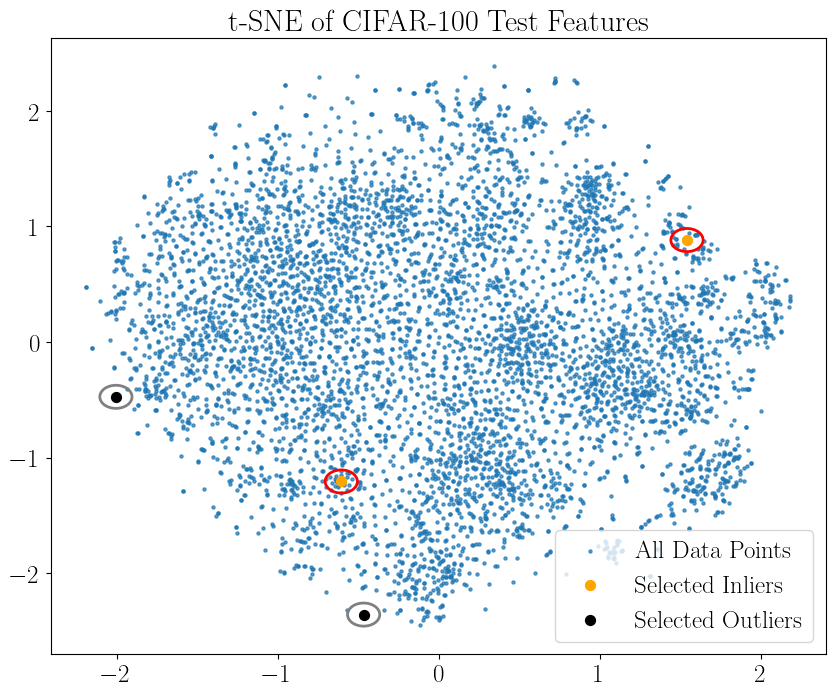

In [45]:
most_cont_idx = np.argsort(contamination_scores)[np.array([6, 9])]
most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([0, 26])]

# Plot all t-SNE coordinates
fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], s=5, alpha=0.7, label='All Data Points')

# Highlight the selected inlier and outlier indexes
inliers_X = X_test_scaled[inlier_indexes, :]
plt.scatter(inliers_X[most_inlier_idx, 0], 
            inliers_X[most_inlier_idx, 1], s=50, color='orange', label='Selected Inliers')

# selecting outliers
outliers_X = X_test_scaled[outlier_indexes, :]
plt.scatter(outliers_X[most_cont_idx, 0], 
            outliers_X[most_cont_idx, 1], s=50, color='black', label='Selected Outliers')
# Decrease the circle size
circle_radius = 0.1

# Draw smaller circles around selected inliers
for x, y in zip(inliers_X[most_inlier_idx, 0], inliers_X[most_inlier_idx, 1]):
    plt.gca().add_patch(plt.Circle((x, y), circle_radius, color='red', fill=False, linewidth=2))

# Draw smaller circles around selected outliers
for x, y in zip(outliers_X[most_cont_idx, 0], outliers_X[most_cont_idx, 1]):
    plt.gca().add_patch(plt.Circle((x, y), circle_radius, color='grey', fill=False, linewidth=2))

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.title('t-SNE of CIFAR-100 Test Features')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Selecting 4 different outliers and 4 different inliers:

In [46]:
# outlier selection
# from the top 20
most_cont_idx = np.argsort(contamination_scores)[np.array([12, 13, 7, 22])]
most_cont_labels = test_labels[outlier_indexes][most_cont_idx]
most_cont_im = outlier_images[most_cont_idx]

# filtering again:
mdn_outlier_sets = pred_sets_mdn[outlier_indexes]
aps_outlier_sets = pred_sets_aps[outlier_indexes]

most_cont_mdn_sets = mdn_outlier_sets[most_cont_idx]
most_cont_aps_sets = aps_outlier_sets[most_cont_idx]

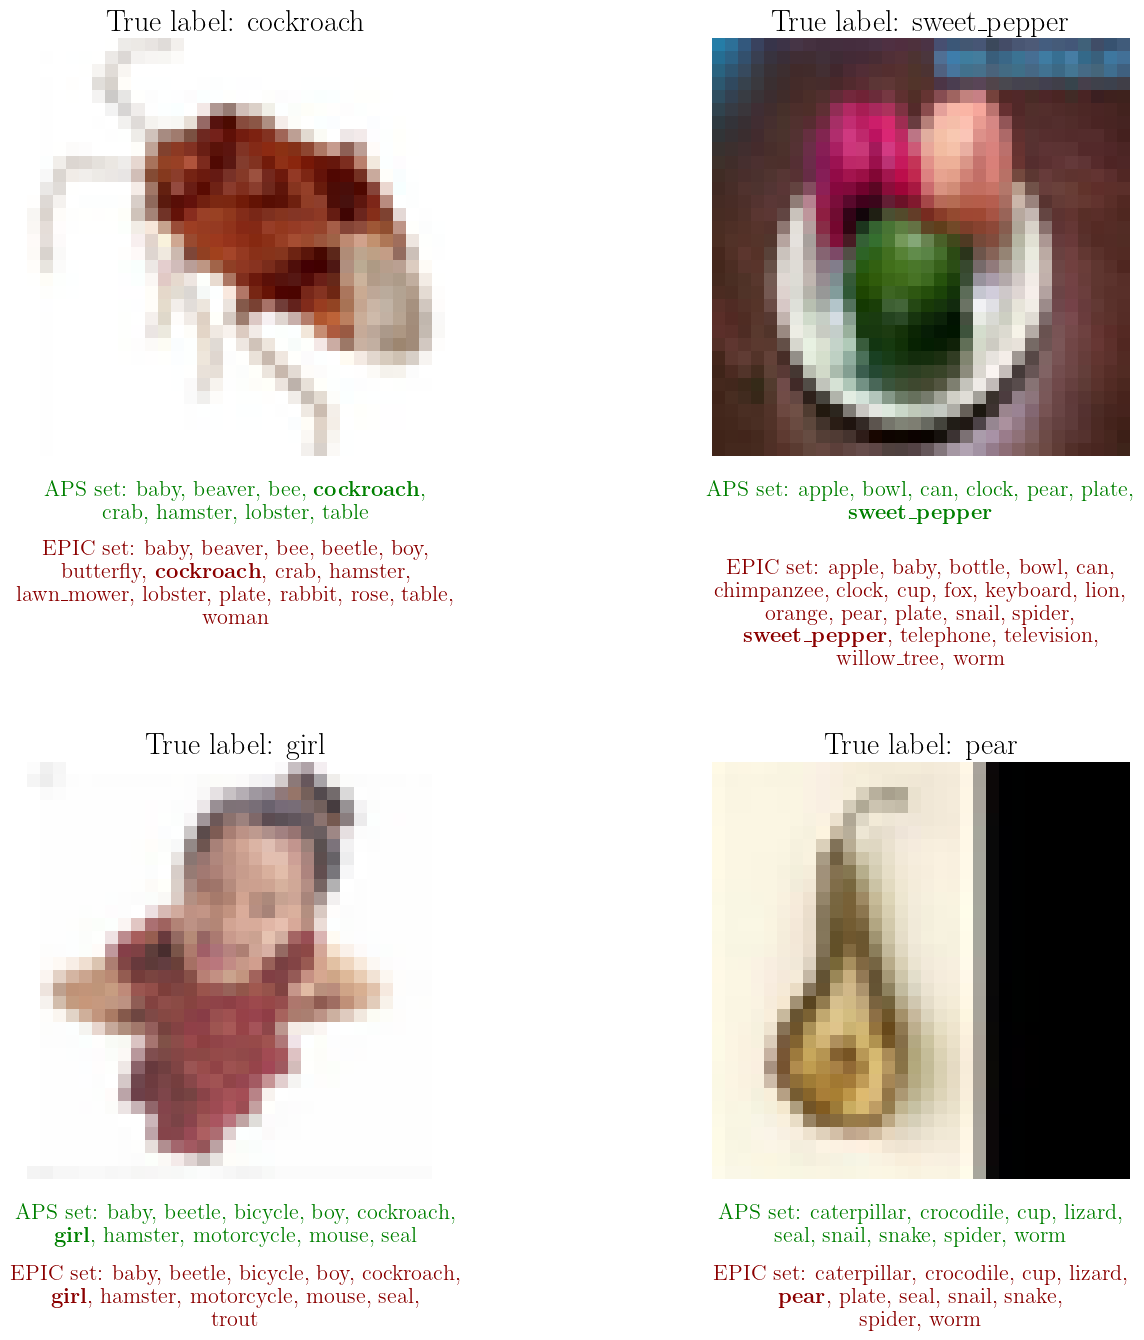

In [47]:
# Define the number of rows and columns for the subplot
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
plt.rcParams.update({'font.size': 18})

# Plot each image with the APS set and EPIC set
for i, ax in enumerate(axes.flat):
    if i < len(most_cont_im):
        ax.imshow(most_cont_im[i].astype(np.uint8))
        true_label = most_cont_labels[i]
        aps_set = list(label_strings[most_cont_aps_sets[i, :]])
        mdn_set = list(label_strings[most_cont_mdn_sets[i, :]])

        if label_strings[true_label] in aps_set:
            aps_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in aps_set]
        else:
            aps_set_highlighted = aps_set

        if label_strings[true_label] in mdn_set:
            mdn_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in mdn_set]
        else:
            mdn_set_highlighted = mdn_set

        # Adjust the spacing of the text
        aps_text = "APS set: {}".format(", ".join(aps_set_highlighted))
        mdn_text = "EPIC set: {}".format(", ".join(mdn_set_highlighted))

        # Wrap the text to fit within the plot
        aps_text_wrapped = "\n".join(textwrap.wrap(aps_text, width=50))
        mdn_text_wrapped = "\n".join(textwrap.wrap(mdn_text, width=50))

        ax.set_title(f"True label: {label_strings[true_label]}")
        ax.axis('off')
        if i == 1:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.5, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')
        elif i == 0:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.4, mdn_text_wrapped, wrap=True, horizontalalignment=
            'center', fontsize=16, transform=ax.transAxes, color='darkred')
        else:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.35, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')

plt.tight_layout()
plt.show()

Plotting 4 inliers:

In [48]:
# plotting 4 inliers

# Identify inliers (non-outliers)
inlier_indexes = np.setdiff1d(np.arange(len(test_images)), outlier_indexes)

# Select the 4 most common inliers based on the highest scores (least negative)
inlier_scores = lof.negative_outlier_factor_[inlier_indexes]
# most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([0, 26, 18])]
most_inlier_idx = np.argsort(inlier_scores)[::-1][np.array([18, 16, 15, 6])]
most_common_inlier_indexes = inlier_indexes[most_inlier_idx]

# Select the most common images among inliers
most_common_inlier_labels = test_labels[most_common_inlier_indexes]
most_common_inlier_images = test_images[most_common_inlier_indexes]

# Obtain the prediction sets for these most common inlier images
most_common_inlier_aps_sets = pred_sets_aps[most_common_inlier_indexes]
most_common_inlier_mdn_sets = pred_sets_mdn[most_common_inlier_indexes]

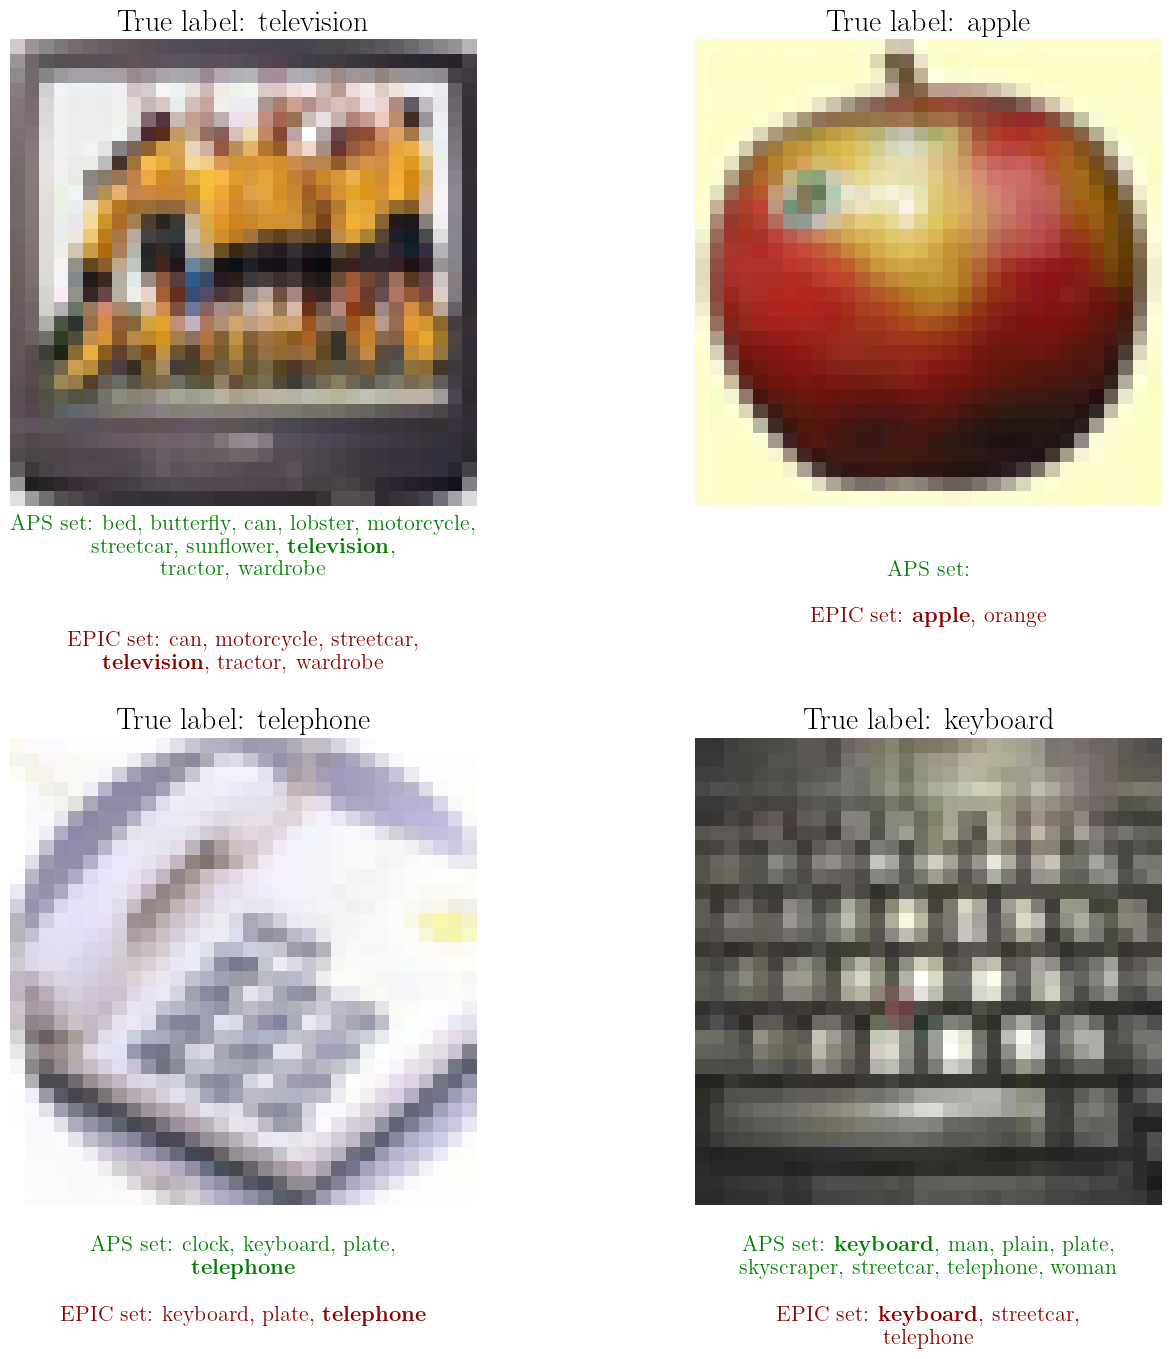

In [49]:
# Define the number of rows and columns for the subplot
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
plt.rcParams.update({'font.size': 18})

# Plot each image with the APS set and EPIC set
for i, ax in enumerate(axes.flat):
    if i < len(most_common_inlier_images):
        ax.imshow(most_common_inlier_images[i].astype(np.uint8))
        true_label = most_common_inlier_labels[i]
        aps_set = list(label_strings[most_common_inlier_aps_sets[i, :]])
        mdn_set = list(label_strings[most_common_inlier_mdn_sets[i, :]])

        if label_strings[true_label] in aps_set:
            aps_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in aps_set]
        else:
            aps_set_highlighted = aps_set

        if label_strings[true_label] in mdn_set:
            mdn_set_highlighted = [r"$\textbf{" + label + "}$" if label == label_strings[true_label] else label for label in mdn_set]
        else:
            mdn_set_highlighted = mdn_set

        # Adjust the spacing of the text
        aps_text = "APS set: {}".format(", ".join(aps_set_highlighted))
        mdn_text = "EPIC set: {}".format(", ".join(mdn_set_highlighted))

        # Wrap the text to fit within the plot
        aps_text_wrapped = "\n".join(textwrap.wrap(aps_text, width=50))
        mdn_text_wrapped = "\n".join(textwrap.wrap(mdn_text, width=50))

        ax.set_title(f"True label: {label_strings[true_label]}")
        ax.axis('off')
        if i == 3:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.3, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')
        elif i == 0:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.35, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')
        else:
            ax.text(0.5, -0.15, aps_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='green')
            ax.text(0.5, -0.25, mdn_text_wrapped, wrap=True, horizontalalignment='center', fontsize=16, transform=ax.transAxes, color='darkred')

plt.tight_layout()
plt.show()

### Comparing prediction set sizes in top 150 outliers and inliers:

/tmp/ipykernel_64463/3627609557.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_1 = axes[0].boxplot([freq_mdn_outlier, freq_aps_outlier],
/tmp/ipykernel_64463/3627609557.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_2 = axes[1].boxplot([freqs_inlier_mdn, freqs_inlier_aps],


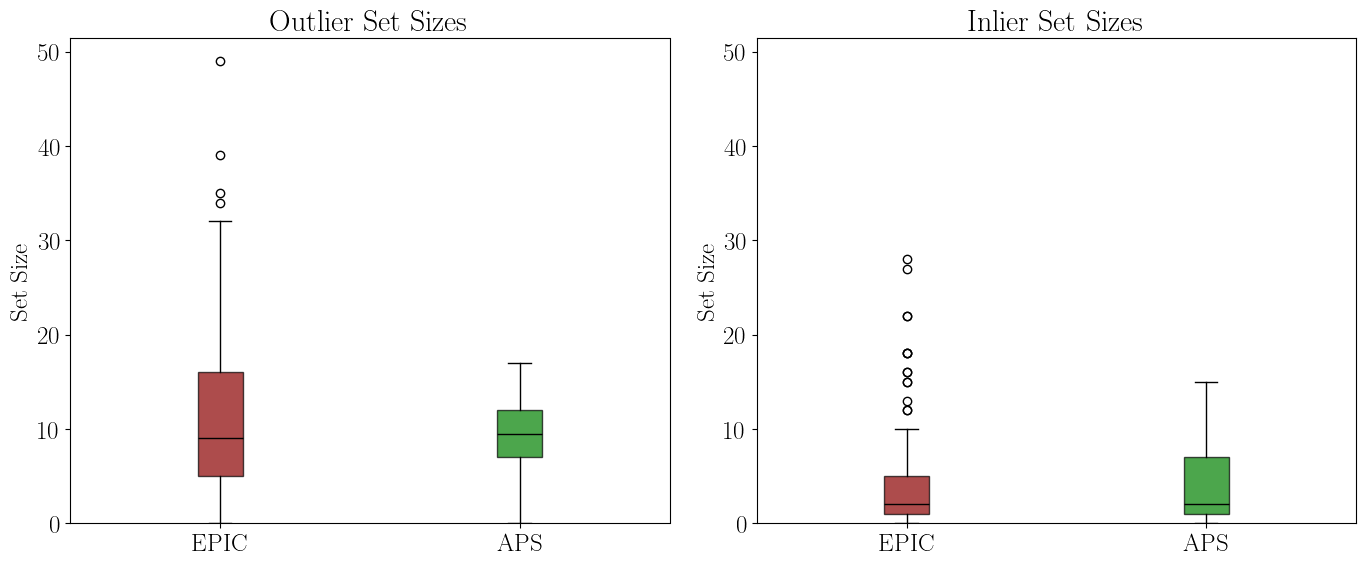

In [51]:
# computing the cardinality of the top outlier sets
most_cont_idx = np.argsort(contamination_scores)

# Select the top 50% of outliers based on contamination scores
size_outliers = 150
top_outlier_indexes = np.argsort(contamination_scores)[:size_outliers]
selected_outlier_indexes = outlier_indexes[top_outlier_indexes]
selected_outlier_mdn_sets = pred_sets_mdn[selected_outlier_indexes]
selected_outlier_aps_sets = pred_sets_aps[selected_outlier_indexes]

# cardinality for selected outliers
freq_mdn_outlier = selected_outlier_mdn_sets.sum(axis = 1)
freq_aps_outlier = selected_outlier_aps_sets.sum(axis = 1)

# Select the 4 most common inliers based on the highest scores (least negative)
inlier_scores = lof.negative_outlier_factor_[inlier_indexes]
inlier_mdn = pred_sets_mdn[inlier_indexes]
inlier_aps = pred_sets_aps[inlier_indexes]
# returning the top 150 of most inliers observations
size = 150
most_inlier_idxs = np.argsort(inlier_scores)[::-1][:size]
inlier_mdn_sets = inlier_mdn[most_inlier_idxs]
inlier_aps_sets = inlier_aps[most_inlier_idxs]

# computing the cardinality of the inlier sets
freqs_inlier_mdn = inlier_mdn_sets.sum(axis=1)
freqs_inlier_aps = inlier_aps_sets.sum(axis=1)

# Plotting the frequencies as boxplots in different panels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for outlier sets
bplot_1 = axes[0].boxplot([freq_mdn_outlier, freq_aps_outlier],
                 labels=['EPIC', 'APS'],
                 patch_artist=True,
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='black'),
                 capprops=dict(color='black'),
                 flierprops=dict(color='black', markeredgecolor='black')
                 )

axes[0].set_title('Outlier Set Sizes')
axes[0].set_ylabel('Set Size')

# Boxplot for inlier sets
bplot_2 = axes[1].boxplot([freqs_inlier_mdn, freqs_inlier_aps],
                labels=['EPIC', 'APS'],
                patch_artist=True,
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(color='black', markeredgecolor='black')
                )
axes[1].set_title('Inlier Set Sizes')
axes[1].set_ylabel('Set Size')
axes[0].set_ylim(0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
axes[1].set_ylim(0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))

# Color the boxplots
colors = ['darkred', 'green']
for patch, color in zip(axes[0].artists, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for patch, color in zip(axes[1].artists, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)


# Color the boxplots
colors = ['darkred', 'green']
for patch, color in zip(bplot_1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for patch, color in zip(bplot_2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.tight_layout()
plt.show()